In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import layers, Model, Sequential
from keras.metrics import Accuracy, Precision, Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import os

Форма X: (100, 128, 128, 3)
Форма y: (100, 128, 128, 1)
Размер изображений: 128


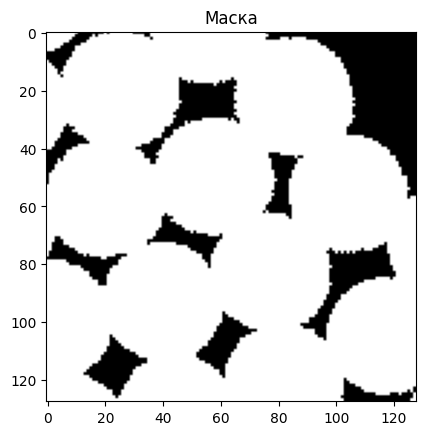

In [6]:

# Загрузка данных
current_directory = os.path.dirname(os.getcwd())
data_dir = os.path.join(current_directory, 'pictures', 'lab6_data_images', 'saved')

X = pd.read_csv(f"{data_dir}/imgs.csv")
y = pd.read_csv(f"{data_dir}/msks.csv")

# Удаление лишнего столбца
X.drop(['Unnamed: 0'], axis=1, inplace=True)
y.drop(['Unnamed: 0'], axis=1, inplace=True)

# Преобразование в массивы NumPy
X = np.array(X / 255, dtype=np.float32)
y = np.array(y, dtype=np.int32)

# Преобразование масок
y[y != 1] = 255
y = (y == 255).astype(np.int32)

# Вычисление размера изображений
img_size = int(np.sqrt(X.shape[1] // 3))
if img_size ** 2 * 3 != X.shape[1]:
    raise ValueError("Размеры данных не соответствуют ожидаемым значениям.")

# Преобразование данных в тензоры
X = X.reshape(len(X), img_size, img_size, 3)
y = y.reshape(len(y), img_size, img_size, 1)

# Визуализация
print("Форма X:", X.shape)
print("Форма y:", y.shape)
print("Размер изображений:", img_size)

plt.imshow(y[0].squeeze(), cmap="gray")
plt.title("Маска")
plt.show()

In [7]:
# Разделение данных на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# === Полносвязная нейронная сеть ===
dropout_rate = 0.2

fc_model = Sequential([
    layers.Input(shape=(img_size, img_size, 3)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(dropout_rate),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(dropout_rate),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(dropout_rate),
    layers.Dense(img_size * img_size, activation='sigmoid'),
    layers.Reshape((img_size, img_size, 1))
])

fc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Обучение полносвязной модели

fc_model.fit(x_train, y_train, batch_size=20, epochs=10, validation_split=0.1)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5096 - loss: 0.6956 - val_accuracy: 0.4349 - val_loss: 1.3669
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6144 - loss: 0.6662 - val_accuracy: 0.3973 - val_loss: 2.3388
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6777 - loss: 0.6322 - val_accuracy: 0.3759 - val_loss: 3.3562
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7130 - loss: 0.5961 - val_accuracy: 0.3708 - val_loss: 3.8932
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7212 - loss: 0.5787 - val_accuracy: 0.3566 - val_loss: 4.6560
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7381 - loss: 0.5582 - val_accuracy: 0.3332 - val_loss: 5.0597
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7492 - loss: 0.5433 - val_accuracy: 0.3108 - val_loss: 5.4521
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7549 - loss: 0.5414 - val_accuracy: 0.2967 - val_loss: 5.8840
Epoch 9/10
4/4

In [10]:
# === Нейронная сеть архитектуры U-Net ===

#ищем локальные признаки
def double_conv_block(x, filters):
    x = layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, filters):
    f = double_conv_block(x, filters)
    p = layers.MaxPool2D(pool_size=2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, filters):
    x = layers.Conv2DTranspose(filters, kernel_size=2, strides=2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, filters)
    return x

def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Слой свертки вниз
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Бутылочное горлышко
    bottleneck = double_conv_block(p4, 1024)

    # Слой развертки вверх
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Выходной слой
    outputs = layers.Conv2D(1, kernel_size=1, activation='sigmoid')(u9)
    return Model(inputs, outputs)

# Построение и компиляция модели
unet_model = build_unet((img_size, img_size, 3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Обучение U-Net модели


unet_model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 125s 34s/step - accuracy: 0.6482 - loss: 0.9662 - val_accuracy: 0.7290 - val_loss: 0.6749
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 112s 23s/step - accuracy: 0.5550 - loss: 0.6750 - val_accuracy: 0.9113 - val_loss: 0.6430
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 83s 23s/step - accuracy: 0.8078 - loss: 0.6439 - val_accuracy: 0.9530 - val_loss: 0.5851
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 23s/step - accuracy: 0.8892 - loss: 0.5861 - val_accuracy: 0.9564 - val_loss: 0.4552
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 25s/step - accuracy: 0.9142 - loss: 0.4561 - val_accuracy: 0.9511 - val_loss: 0.2184
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 96s 29s/step - accuracy: 0.8253 - loss: 0.4641 - val_accuracy: 0.9668 - val_loss: 0.2170
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 128s 24s/step - accuracy: 0.9191 - loss: 0.2909 - val_accuracy: 0.9257 - val_loss: 0.2188
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 88s 24s/step - accuracy: 0.9273 - loss: 0.2133 - val_accuracy: 0.9711 - val_loss: 0.12

In [12]:
# === Анализ результатов ===
def evaluate_model(model, x_data, y_data, model_name):
    predictions = model.predict(x_data)
    predictions_binary = (predictions > 0.5).astype(int)
    acc = accuracy_score(y_data.flatten(), predictions_binary.flatten())
    prec = precision_score(y_data.flatten(), predictions_binary.flatten(), zero_division=0)
    rec = recall_score(y_data.flatten(), predictions_binary.flatten(), zero_division=0)
    print(f"{model_name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

    return predictions

In [13]:
# Оценка полносвязной модели
# Точность-как точно показала,Точность- предсказание на положительность, полнота - доля из всех положительных смогла найти
print("\nПолносвязная модель:")
fc_predictions = evaluate_model(fc_model, x_test, y_test, "Полносвязная модель")

# Оценка U-Net модели
print("\nU-Net модель:")
unet_predictions = evaluate_model(unet_model, x_test, y_test, "U-Net модель")


Полносвязная модель:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Полносвязная модель - Accuracy: 0.2744, Precision: 0.8167, Recall: 0.0886

U-Net модель:
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
U-Net модель - Accuracy: 0.9680, Precision: 0.9780, Recall: 0.9811


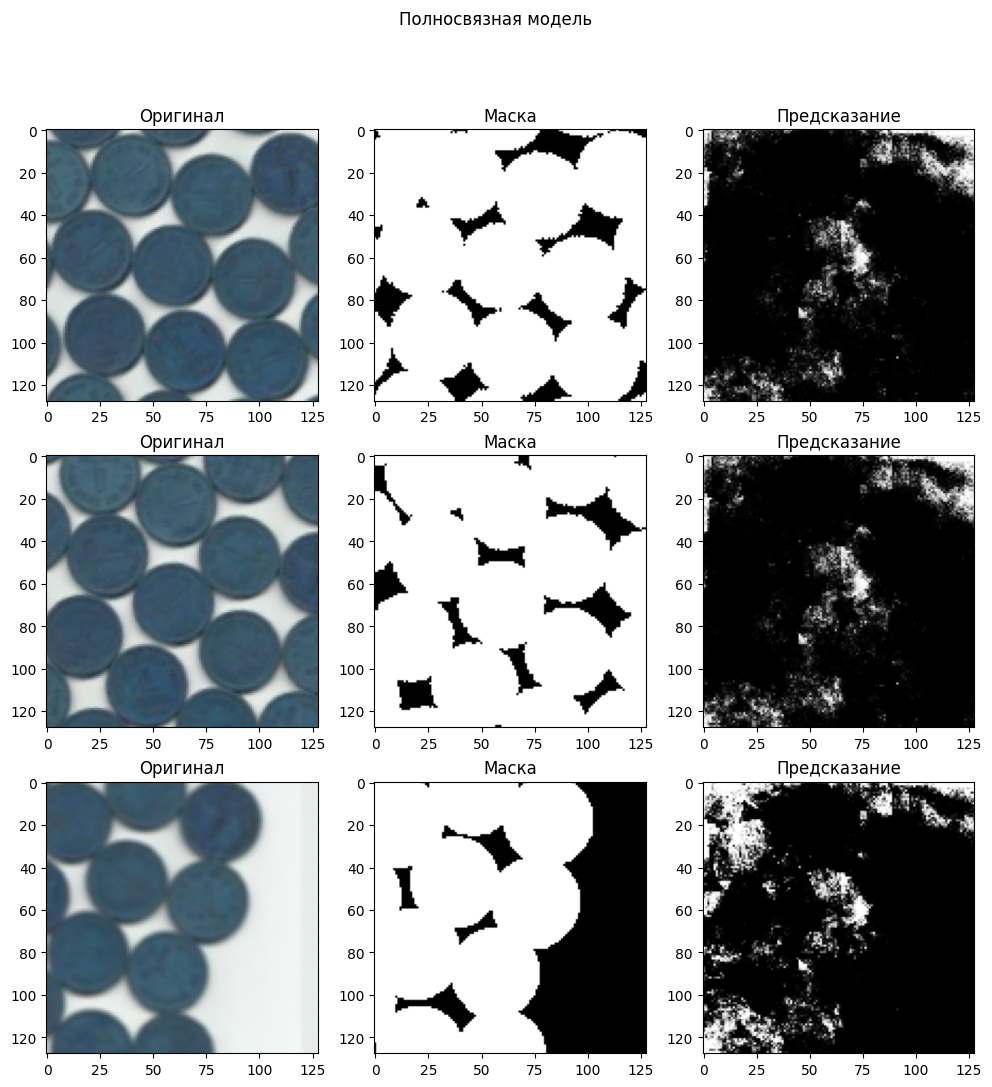

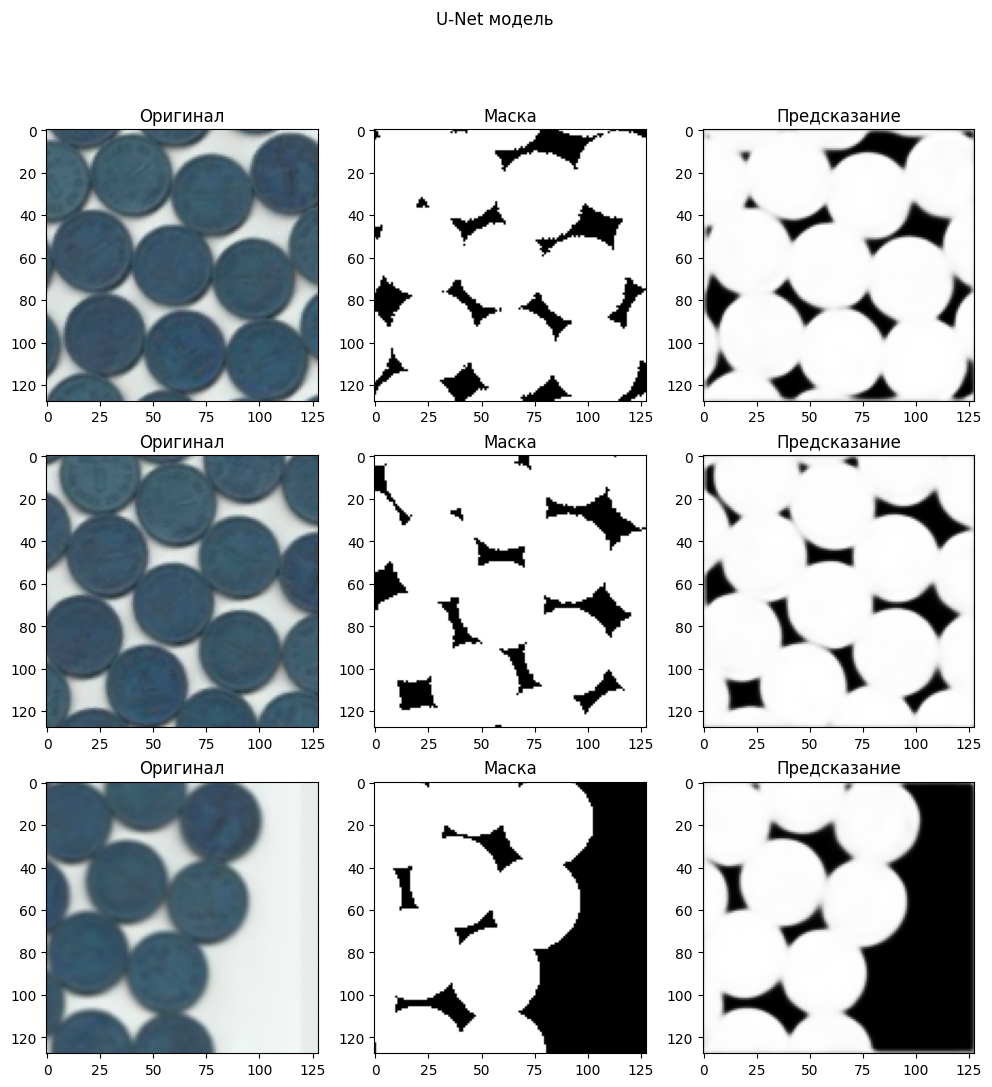

In [14]:
# === Визуализация ===
def visualize_results(images, masks, predictions, title):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i in range(3):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Оригинал")
        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("Маска")
        axes[i, 2].imshow(predictions[i].squeeze(), cmap='gray')
        axes[i, 2].set_title("Предсказание")
    plt.suptitle(title)
    plt.show()

# Визуализация для полносвязной модели
visualize_results(x_test[:3], y_test[:3], fc_predictions[:3], "Полносвязная модель")

# Визуализация для U-Net модели
visualize_results(x_test[:3], y_test[:3], unet_predictions[:3], "U-Net модель")